In [2]:
#exploration des données 

#import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

#chargement du DataFrame
csv_path = "DataFrame.csv"
df = pd.read_csv(csv_path, encoding="utf-8")

#affichage du nombre de lignes et de colonnes
print(f"Le fichier csv contient {df.shape[0]} lignes et {df.shape[1]} colonnes. \n")


#affichage des informations générales
print("--> Informations generales sur le DataFrame : \n")
df.info()

#aperçu des 1eres lignes
print("\n --> Apercu des données")
print(df.head())

#comptage des données manquantes
def compter_manquants(col):
    return ((col.isna()) | (col == "") | (col == "Non disponible")).sum()

#application à chaque colonne
manquants = df.apply(compter_manquants)

#affichage des données manquantes
print("\nNombre de données manquantes par colonne (NaN, vide, ou 'Non disponible') :\n")
print(manquants.sort_values(ascending=False))

# Nettoyage de base
df['CVSS_score'] = pd.to_numeric(df['CVSS_score'], errors='coerce')
df['EPSS_score'] = pd.to_numeric(df['EPSS_score'], errors='coerce')
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df['CWE'] = df['CWE'].fillna("Non classé")
df['Editeur'] = df['Editeur'].fillna("Inconnu")
df['Produit'] = df['Produit'].fillna("Non spécifié")


Le fichier csv contient 134909 lignes et 15 colonnes. 

--> Informations generales sur le DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134909 entries, 0 to 134908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID_ANSSI            134909 non-null  object 
 1   Titre_ANSSI         134909 non-null  object 
 2   Type                134909 non-null  object 
 3   Date_publication    134909 non-null  object 
 4   CVE_ID              134909 non-null  object 
 5   CVSS_score          38622 non-null   float64
 6   Base_Severity       134909 non-null  object 
 7   CWE                 134909 non-null  object 
 8   CWE_description     131629 non-null  object 
 9   EPSS_score          134648 non-null  float64
 10  Lien_bulletin       134909 non-null  object 
 11  Description         134909 non-null  object 
 12  Editeur             128357 non-null  object 
 13  Produit             131346 non

Text(0, 0.5, 'Nombre de CVE')

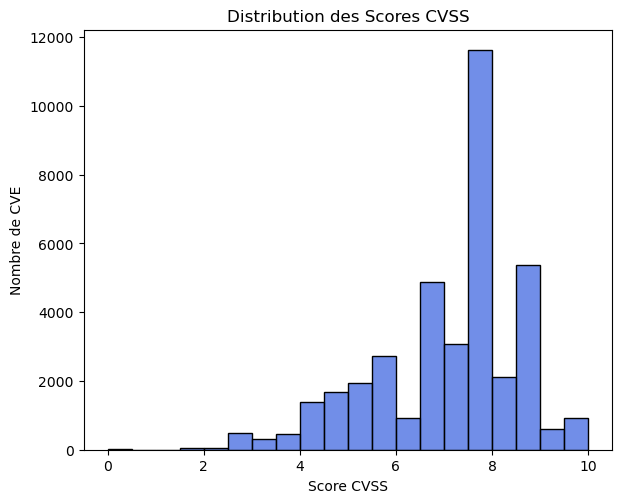

In [23]:
# Étape 5 – Visualisation et Interprétation des CVE enrichies

fig = plt.figure(figsize=(15, 12))

# 1. Histogramme Score CVSS
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='CVSS_score', bins=20, color='royalblue')
plt.title('Distribution des Scores CVSS')
plt.xlabel('Score CVSS')
plt.ylabel('Nombre de CVE')

Text(0.5, 1.0, 'Distribution des Types de Vulnérabilités (CWE)')

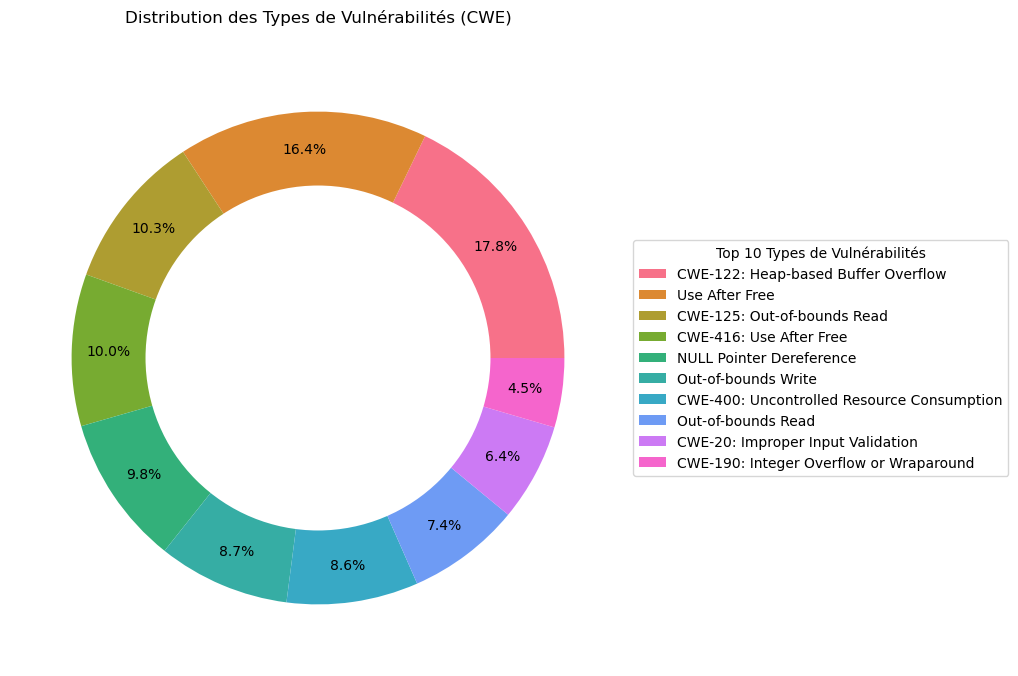

In [27]:
plt.figure(figsize=(20, 8))

# 2. Diagramme circulaire des types de vulnérabilités (CWE)
plt.subplot(1, 2, 1)
# Filter out "Non disponible" and get top 10 CWEs
cwe_data = df[df['CWE_description'] != 'Non disponible']['CWE_description'].value_counts().head(10)

# Create pie chart with better formatting
colors = sns.color_palette('husl', n_colors=len(cwe_data))
patches, texts, autotexts = plt.pie(cwe_data.values, 
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   pctdistance=0.85)

# Add a circle at the center to create a donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Improve legend
plt.legend(patches, cwe_data.index,
          title="Top 10 Types de Vulnérabilités",
          loc="center left",
          bbox_to_anchor=(1, 0.5))
plt.title('Distribution des Types de Vulnérabilités (CWE)', pad=20)

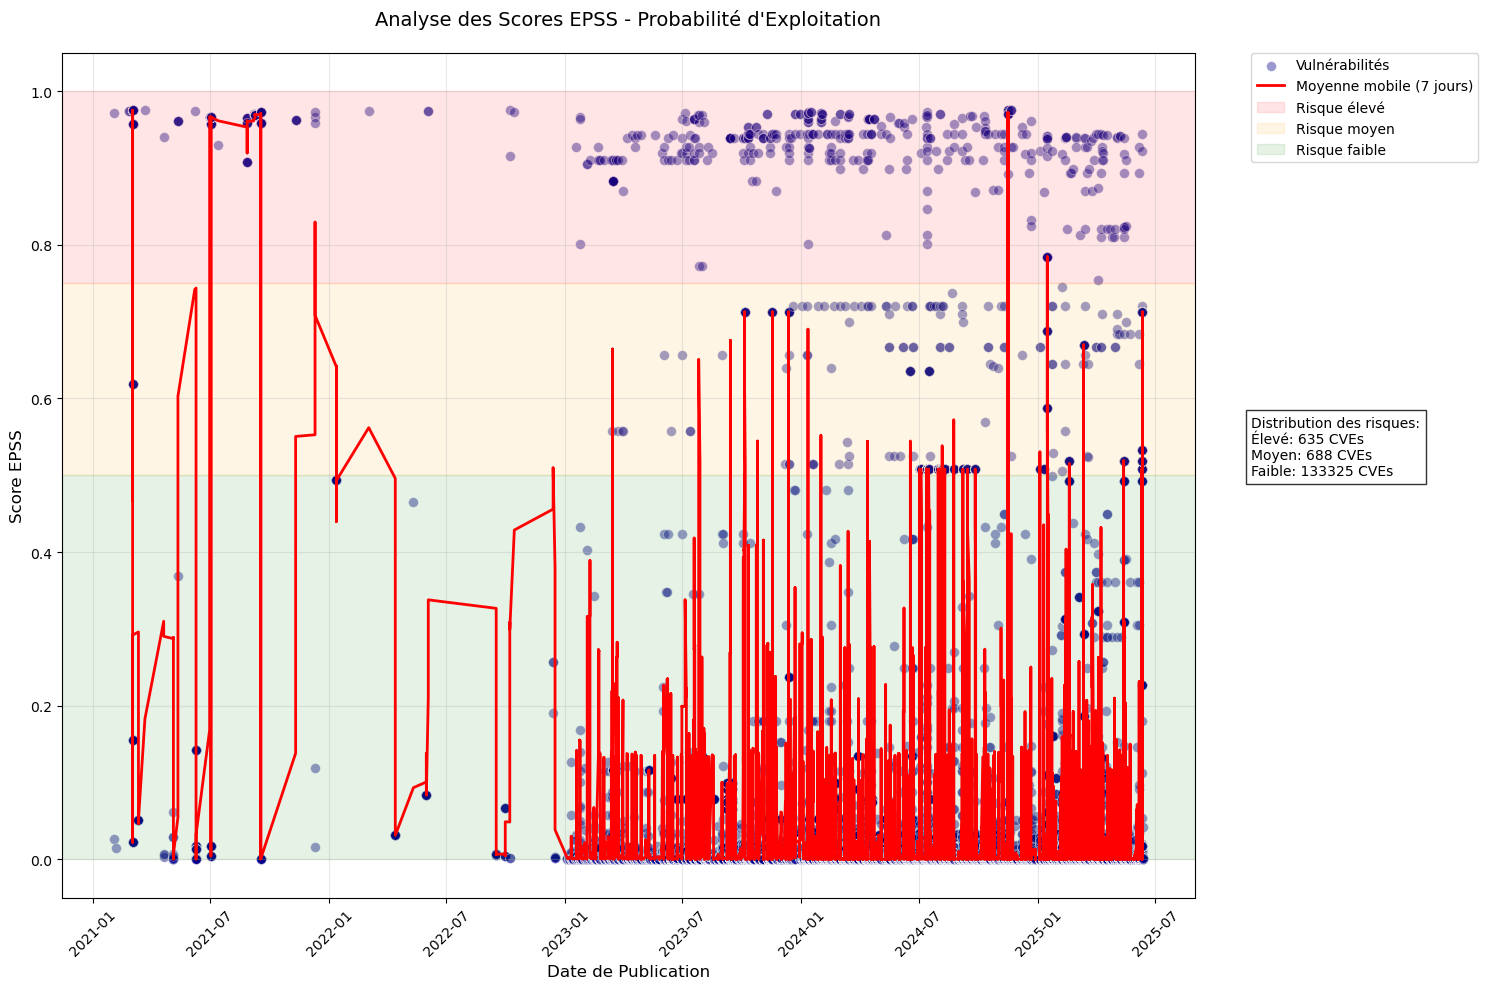


Statistiques des Scores EPSS:
count    134648.000000
mean          0.010345
std           0.077949
min           0.000020
25%           0.000420
50%           0.000450
75%           0.000800
max           0.975150
Name: EPSS_score, dtype: float64


In [37]:
# 3. Courbe des scores EPSS

df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df_sorted = df.sort_values('Date_publication')

# Create main visualization
plt.figure(figsize=(15, 10))

# 1. Scatter plot of vulnerabilities
sns.scatterplot(data=df_sorted, 
                x='Date_publication',
                y='EPSS_score',
                alpha=0.4,
                color='darkblue',
                s=50,
                label='Vulnérabilités')

# 2. Add moving average (7 days)
df_sorted['MA7'] = df_sorted['EPSS_score'].rolling(window=7).mean()
plt.plot(df_sorted['Date_publication'], 
         df_sorted['MA7'], 
         color='red', 
         linewidth=2, 
         label='Moyenne mobile (7 jours)')

# 3. Add risk zones
plt.axhspan(0.75, 1.0, color='red', alpha=0.1, label='Risque élevé')
plt.axhspan(0.5, 0.75, color='orange', alpha=0.1, label='Risque moyen')
plt.axhspan(0, 0.5, color='green', alpha=0.1, label='Risque faible')

# 4. Customize appearance
plt.title('Analyse des Scores EPSS - Probabilité d\'Exploitation', fontsize=14, pad=20)
plt.xlabel('Date de Publication', fontsize=12)
plt.ylabel('Score EPSS', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5. Add informative legend
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.)

# 6. Add risk statistics annotations
high_risk = len(df[df['EPSS_score'] > 0.75])
medium_risk = len(df[(df['EPSS_score'] > 0.5) & (df['EPSS_score'] <= 0.75)])
low_risk = len(df[df['EPSS_score'] <= 0.5])

stats_text = f'Distribution des risques:\nÉlevé: {high_risk} CVEs\nMoyen: {medium_risk} CVEs\nFaible: {low_risk} CVEs'
plt.text(1.05, 0.5, stats_text, 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nStatistiques des Scores EPSS:")
print(df['EPSS_score'].describe())

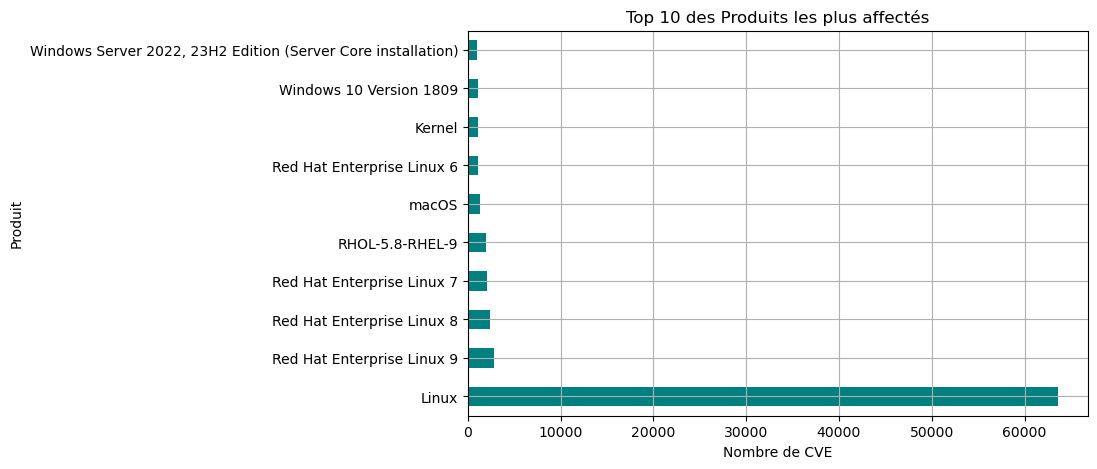

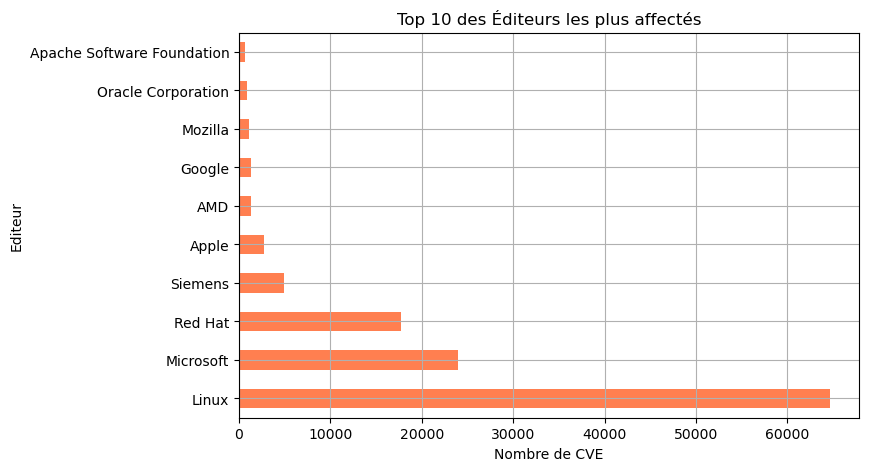

In [39]:
# Classement des produits et éditeurs les plus affectés
plt.figure(figsize=(8,5))
df['Produit'].value_counts().head(10).plot(kind='barh', color='teal')
plt.title("Top 10 des Produits les plus affectés")
plt.xlabel("Nombre de CVE")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
df['Editeur'].value_counts().head(10).plot(kind='barh', color='coral')
plt.title("Top 10 des Éditeurs les plus affectés")
plt.xlabel("Nombre de CVE")
plt.grid(True)
plt.show()

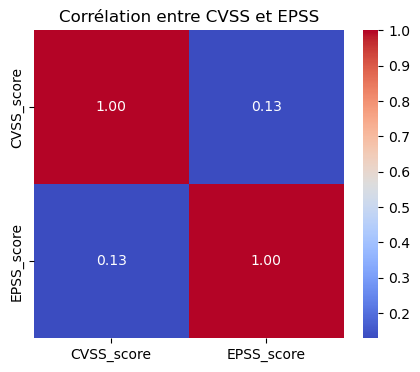

In [41]:
# Heatmap de corrélation CVSS / EPSS
plt.figure(figsize=(5,4))
sns.heatmap(df[['CVSS_score', 'EPSS_score']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

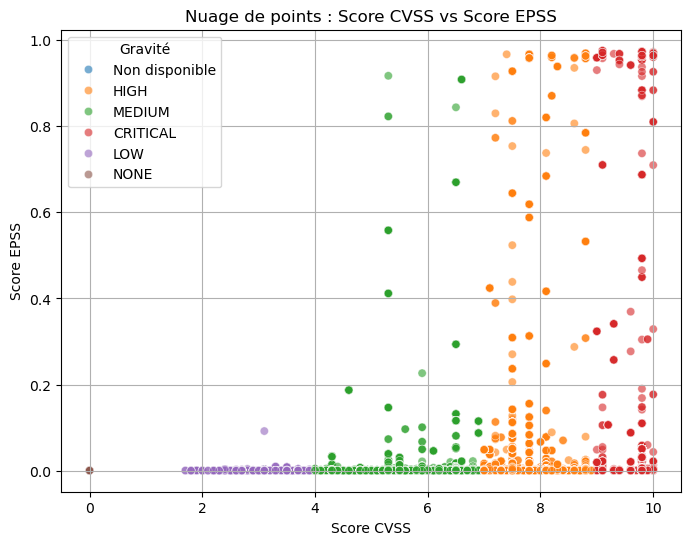

In [43]:
# Nuage de points CVSS vs EPSS
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='CVSS_score', y='EPSS_score', hue='Base_Severity', alpha=0.6)
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.legend(title='Gravité')
plt.show()

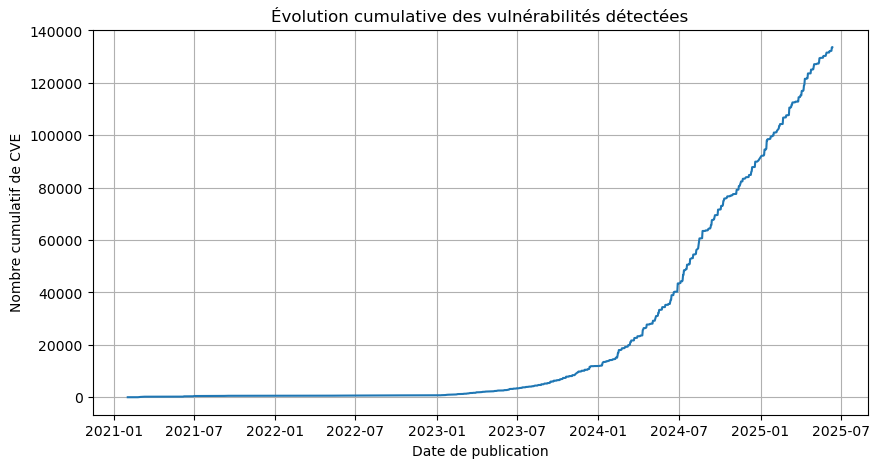

In [45]:
# Courbe cumulative des vulnérabilités dans le temps
plt.figure(figsize=(10,5))
df['Date_publication'].dropna().dt.date.value_counts().sort_index().cumsum().plot()
plt.title("Évolution cumulative des vulnérabilités détectées")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulatif de CVE")
plt.grid(True)
plt.show()

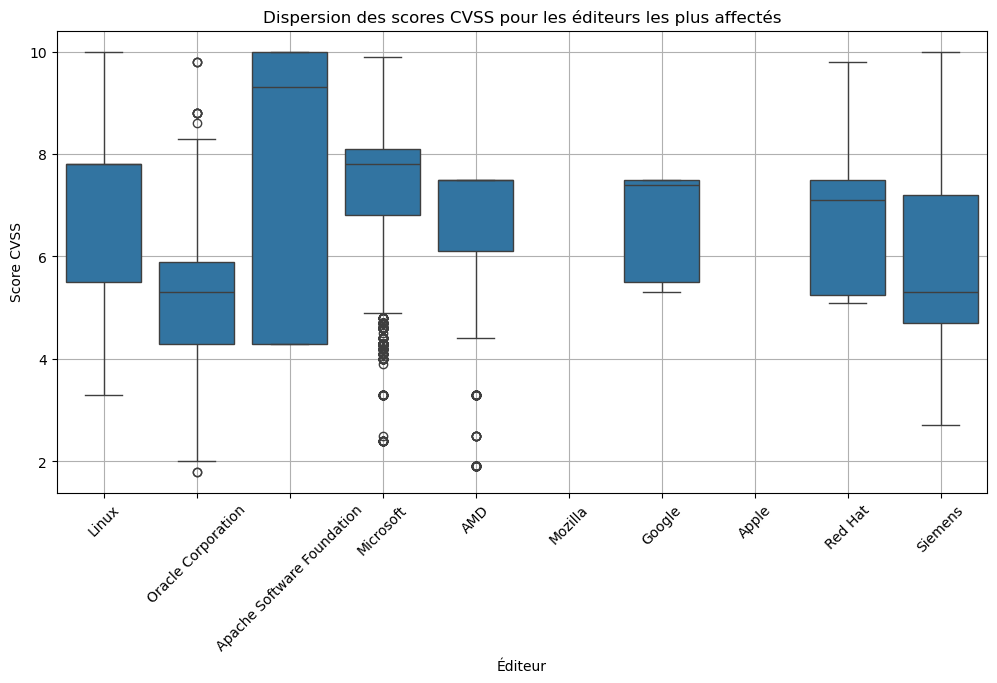

In [47]:
# Boxplot CVSS par éditeur (top 10)
top_editeurs = df['Editeur'].value_counts().head(10).index
df_top = df[df['Editeur'].isin(top_editeurs)]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_top, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS pour les éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

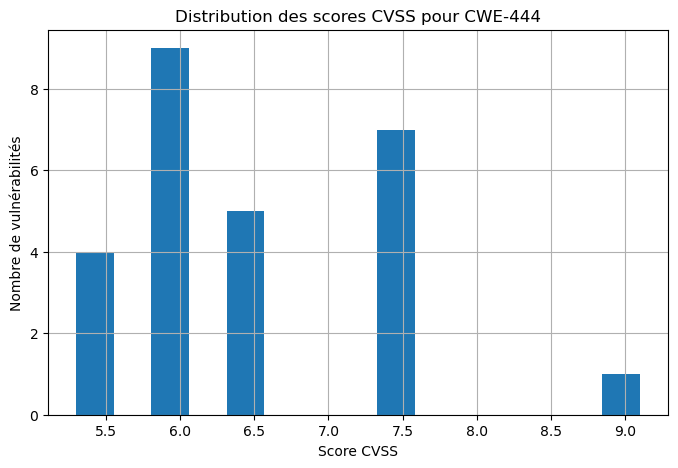

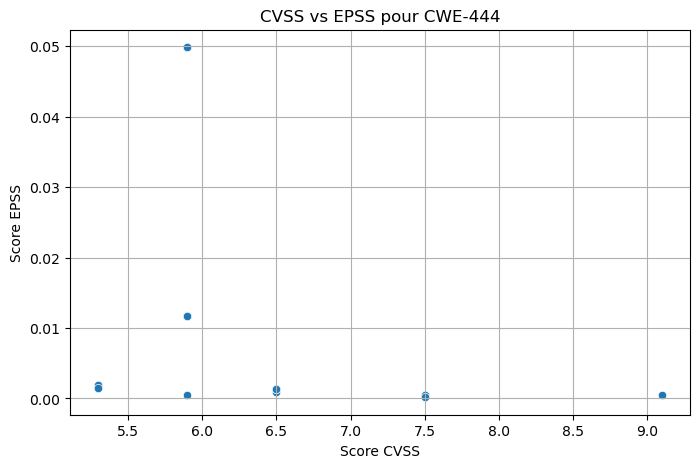

In [49]:
# Visualisation spécifique d'un CWE donné 
selected_cwe = "CWE-444"
df_cwe = df[df['CWE'] == selected_cwe]
plt.figure(figsize=(8,5))
df_cwe['CVSS_score'].hist(bins=15)
plt.title(f"Distribution des scores CVSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_cwe, x='CVSS_score', y='EPSS_score')
plt.title(f"CVSS vs EPSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

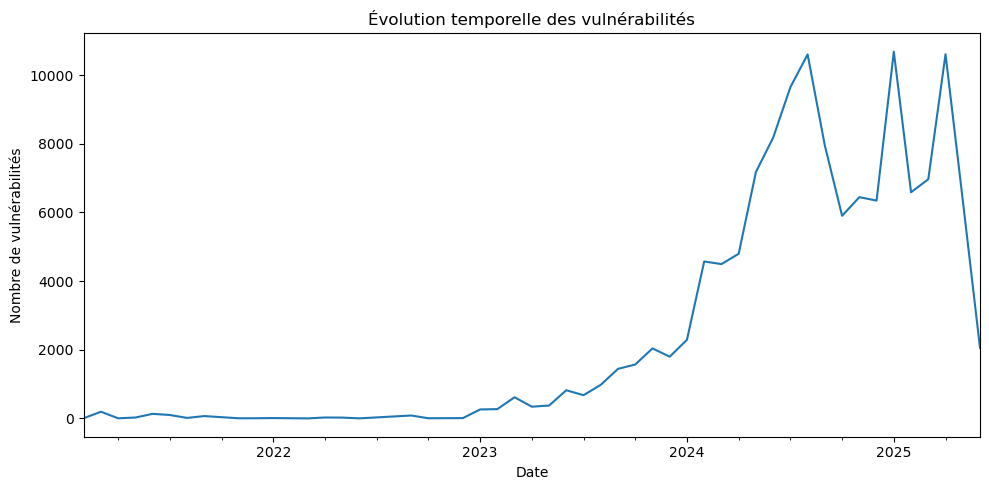

In [51]:
# Evolution temporelle du nombre de vuln\u00e9rabilit\u00e9s
plt.figure(figsize=(10,5))
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df.groupby(df['Date_publication'].dt.to_period('M')).size().plot()
plt.title("\u00c9volution temporelle des vuln\u00e9rabilit\u00e9s")
plt.xlabel("Date")
plt.ylabel("Nombre de vuln\u00e9rabilit\u00e9s")
plt.tight_layout()
plt.show()

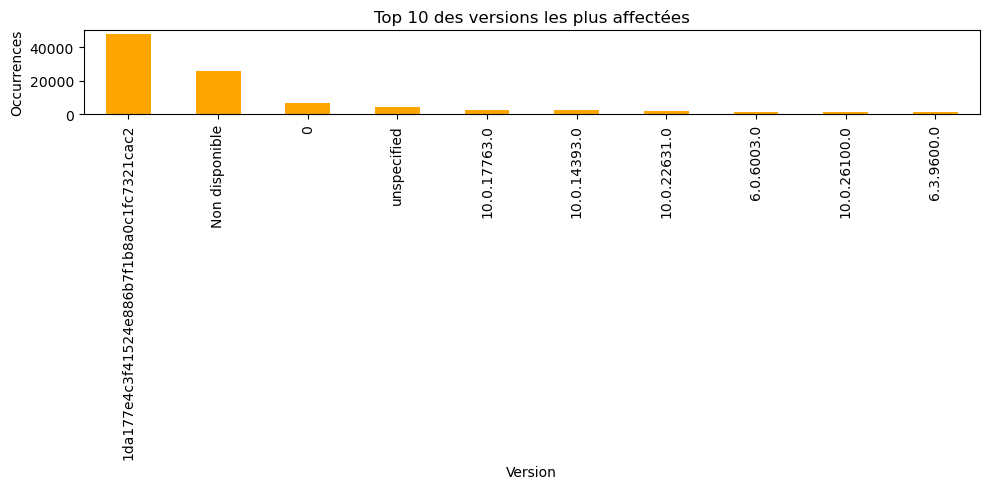

In [53]:
# Versions les plus fréquemment touchées
plt.figure(figsize=(10,5))
versions = df['Versions_affectees'].dropna().str.split(', ')
flat_versions = [v.strip() for sublist in versions for v in sublist if v.strip() != ""]
pd.Series(flat_versions).value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 des versions les plus affect\u00e9es")
plt.xlabel("Version")
plt.ylabel("Occurrences")
plt.tight_layout()
plt.show()

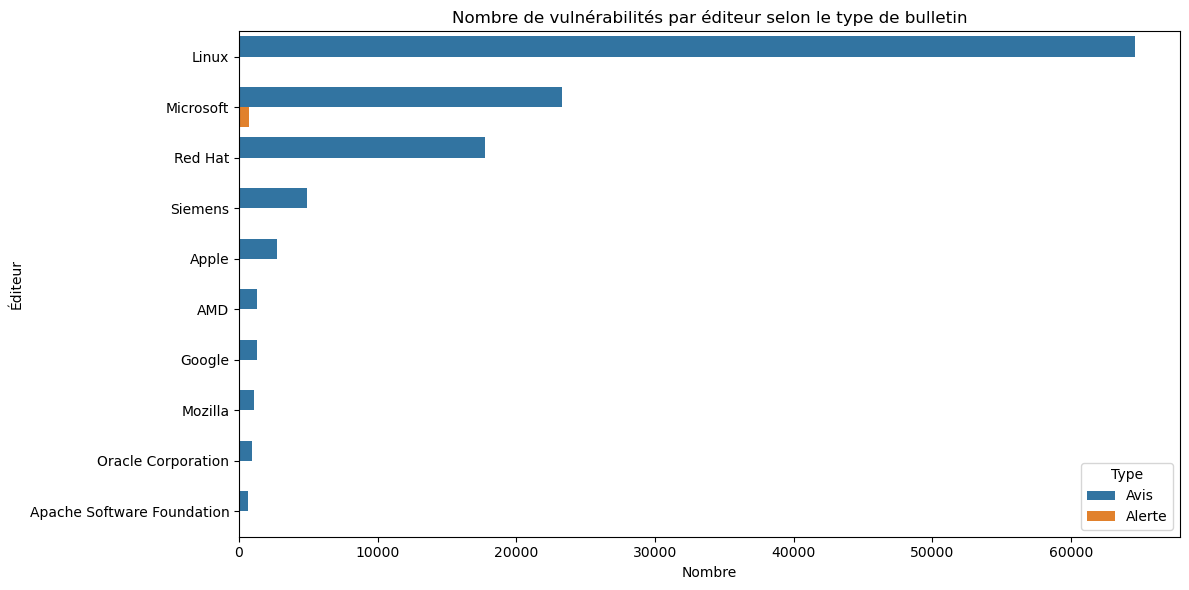

In [55]:
# Nombre de vulnérabilitées par éditeur et type de bulletin
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Editeur', hue='Type', order=df['Editeur'].value_counts().head(10).index)
plt.title("Nombre de vuln\u00e9rabilit\u00e9s par \u00e9diteur selon le type de bulletin")
plt.xlabel("Nombre")
plt.ylabel("\u00c9diteur")
plt.tight_layout()
plt.show()

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\1696579044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)


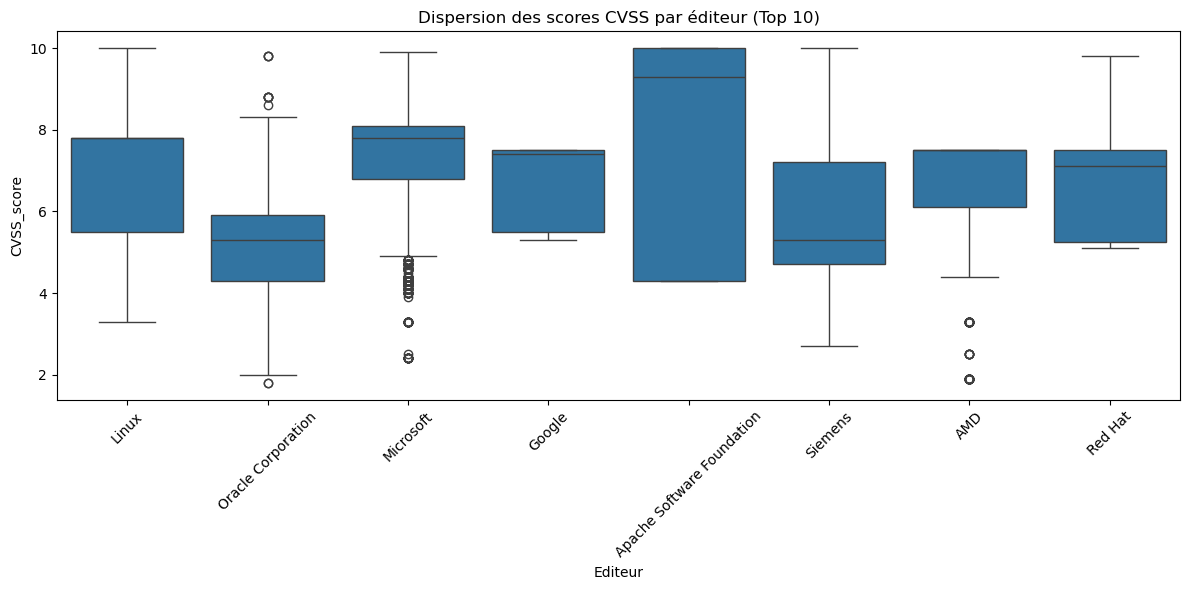

In [57]:
# Dispersion des scores CVSS pour les éditeurs les plus affectées
top_editors = df['Editeur'].value_counts().head(10).index
df_filtered = df[df['Editeur'].isin(top_editors) & df['CVSS_score'].notna()]
df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_filtered, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS par \u00e9diteur (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

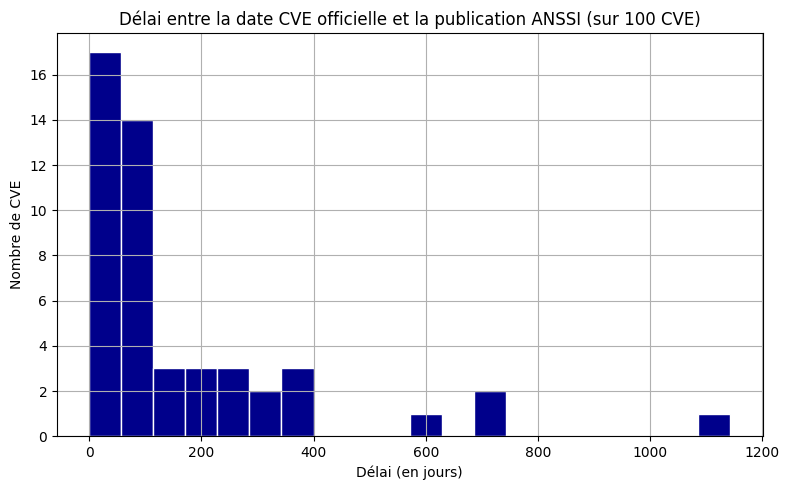

📊 Moyenne du délai : 166.0 jours
📈 Médiane : 82.0 jours
📉 Minimum : 0.0 jours
📈 Maximum : 1143.0 jours


In [3]:
import pandas as pd
import requests

# Charger les données ANSSI
df = pd.read_csv("DataFrame.csv")
df = df.dropna(subset=["CVE_ID", "Date_publication"])

# Forcer les dates ANSSI à être des datetime sans fuseau horaire
df["Date_publication"] = pd.to_datetime(df["Date_publication"], errors="coerce").dt.tz_localize(None)

# Fonction pour récupérer la date officielle de la CVE depuis l'API MITRE
def get_cve_date(cve_id):
    try:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get("cveMetadata", {}).get("datePublished")
    except Exception as e:
        print(f"⚠️ Erreur récupération date pour {cve_id}: {e}")
        return None

# Sélectionner un échantillon pour test (éviter surcharge API)
sample = df.drop_duplicates(subset=["CVE_ID"]).head(100).copy()

# Obtenir les dates CVE
sample["Date_CVE"] = sample["CVE_ID"].apply(get_cve_date)
sample["Date_CVE"] = pd.to_datetime(sample["Date_CVE"], errors="coerce").dt.tz_localize(None)

# Calculer le délai en jours
sample["Delai_jours"] = (sample["Date_publication"] - sample["Date_CVE"]).dt.days
sample = sample.dropna(subset=["Delai_jours"])
sample = sample[sample["Delai_jours"] >= 0]

# Afficher l'histogramme des délais
plt.figure(figsize=(8,5))
sample["Delai_jours"].hist(bins=20, color="darkblue", edgecolor="white")
plt.title("Délai entre la date CVE officielle et la publication ANSSI (sur 100 CVE)")
plt.xlabel("Délai (en jours)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistiques
print("📊 Moyenne du délai :", round(sample["Delai_jours"].mean(), 2), "jours")
print("📈 Médiane :", sample["Delai_jours"].median(), "jours")
print("📉 Minimum :", sample["Delai_jours"].min(), "jours")
print("📈 Maximum :", sample["Delai_jours"].max(), "jours")

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\2003815741.py:20: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\anael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


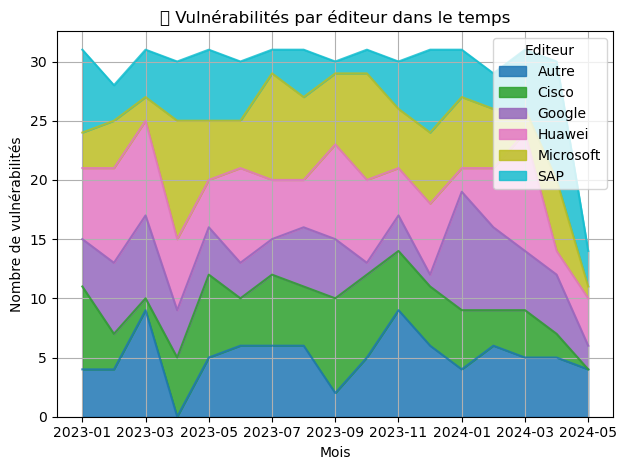

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\2003815741.py:44: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\anael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


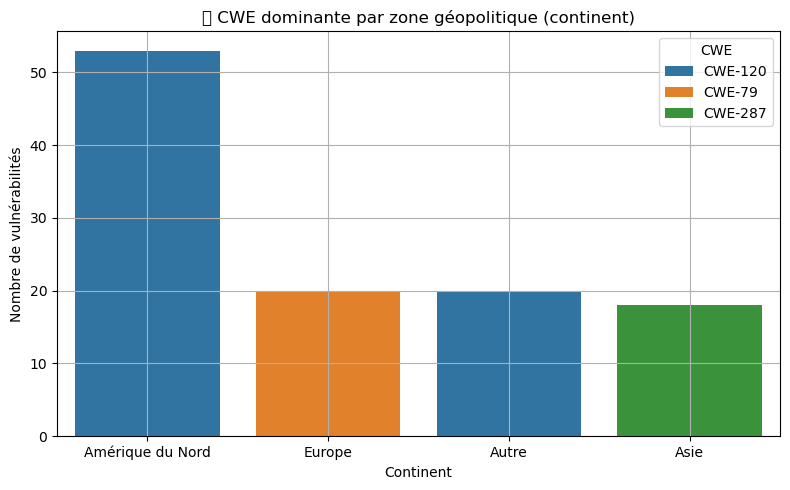

In [61]:
# Données fictives réalistes
np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Date_publication": pd.date_range("2023-01-01", periods=n, freq="D"),
    "Editeur": np.random.choice(["Microsoft", "Google", "Cisco", "Huawei", "SAP", "Autre"], size=n),
    "CWE": np.random.choice(["CWE-79", "CWE-89", "CWE-287", "CWE-20", "CWE-120", "Non classé"], size=n)
})

# 🧱 Stacked Timeline
df["Mois"] = df["Date_publication"].dt.to_period("M").astype(str)
timeline = df.groupby(["Mois", "Editeur"]).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
timeline.plot(kind="area", stacked=True, colormap="tab10", alpha=0.85)
plt.title("🧱 Vulnérabilités par éditeur dans le temps")
plt.ylabel("Nombre de vulnérabilités")
plt.xlabel("Mois")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📍 Mapping éditeur → continent
editeur_continent = {
    "Microsoft": "Amérique du Nord",
    "Google": "Amérique du Nord",
    "Cisco": "Amérique du Nord",
    "Huawei": "Asie",
    "SAP": "Europe",
    "Autre": "Autre"
}
df["Continent"] = df["Editeur"].map(editeur_continent)

# CWE dominante par continent
cwe_counts = df.groupby(["Continent", "CWE"]).size().reset_index(name="count")
top_cwe_by_continent = cwe_counts.sort_values("count", ascending=False).drop_duplicates("Continent")

plt.figure(figsize=(8,5))
sns.barplot(data=top_cwe_by_continent, x="Continent", y="count", hue="CWE")
plt.title("📍 CWE dominante par zone géopolitique (continent)")
plt.ylabel("Nombre de vulnérabilités")
plt.xlabel("Continent")
plt.grid(True)
plt.tight_layout()
plt.show()